In [326]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 

In [327]:
movie = pd.read_csv("/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv")

# Overview

Overview of variable types, form and checking for missing values

In [328]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


Things to bear in mind:

* Released Year, Runtime, Gross are being treated as objects when it should be numeric of some sort
* Genre is a string which can contain more than one genre
* Meta_Score, Certificate and Gross have missing values
* Star1, Star2, Star3, Star4 may have to be converted to long format


### What to look for

**Questions**

* Does the general public rating (IMDB_Rating) walk hand-in-hand with the specialized critic's ratings (Meta_score)? On what films do these scores differ? Is there a pattern?

* Do well rated films have a higher gross revenue? What movies don't follow such a pattern?

* What is the relation between the targeted age group and ratings? Do family-friendly films have lower ratings than age-restricted ones?

* Other questions concern Score x Runtime, Released Year x Runtime, Stars in the cast x Revenue, ...

# Preprocessing with preliminary analysis on the way

Drop unnecessary columns: Poster Link, Overview

In [329]:
movie.drop(["Poster_Link", "Overview"], axis=1, inplace=True)

### Certificate

**Problem**: The variable *certificate* is not standardized, possibly because of the different rating systems across countries and epochs, therefore it depends on the nationality and release year of the film.

In [330]:
movie["Certificate"].value_counts()

Certificate
U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: count, dtype: int64

**Solution**: Aggregate certificates based on the age group they are meant for, inspired by the Brazilian rating system

Looking up the different rating systems and making concessions we have the approximate mapping:

* L: PG, U, G
* 12+: U/A, TV-PG, UA, Passed, Approved
* 14+: PG-13, TV-14
* 16+: 16, A, R, TV-MA
* NaN: Unrated

Sources: 

* https://en.wikipedia.org/wiki/Motion_picture_content_rating_system
* https://en.wikipedia.org/wiki/Central_Board_of_Film_Certification
* https://en.wikipedia.org/wiki/TV_Parental_Guidelines



In [331]:
certificates = {
    "PG": "L", "U": "L", "G": "L",
    "U/A":"12+", "TV-PG":"12+", "UA": "12+", "Passed": "12+", "Approved":"12+",
    "PG-13": "14+", "TV-14":"14+",
    "16":"16+", "A":"16+", "R":"16+", "TV-MA":"16+",
    "Unrated": np.nan
}
movie["Certificate"] = pd.Categorical(movie["Certificate"].map(certificates), categories=["L", "12+", "14+", "16+"],
                                     ordered=True)

<Axes: xlabel='Certificate'>

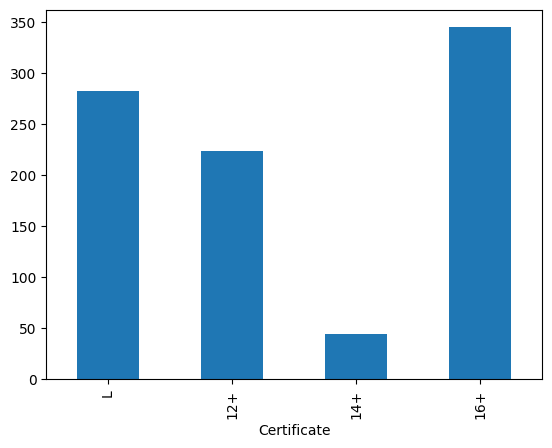

In [332]:
movie["Certificate"].value_counts().sort_index().plot(kind="bar")

Except for 14+ , there seems to be a balanced mix of ratings among the 1000 top IMDB movies. The scarcity of the 14+ badge is probably due to the concessions that had to be made to construct the mapping.

#### Scores x Certificate

<Axes: xlabel='Certificate', ylabel='Meta_score'>

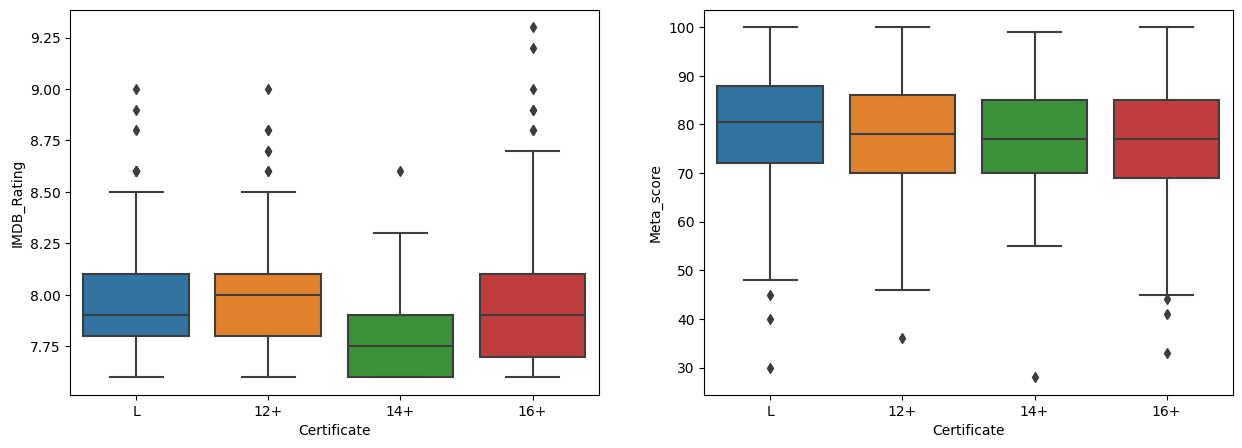

In [333]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.boxplot(x="Certificate", y="IMDB_Rating", data=movie, ax=ax1)
sns.boxplot(x="Certificate", y="Meta_score", data=movie, ax=ax2)

Not much here, the difference in ratings among certificates is either small or doesn't follow a clear pattern.

#### Runtime

First, convert the *runtime* variable from string to float 

In [334]:
movie['Runtime'][1]

'175 min'

In [335]:
movie['Runtime'] = movie['Runtime'].map(lambda x: float(x.replace(' min', '')))

count    1000.000000
mean      122.891000
std        28.093671
min        45.000000
25%       103.000000
50%       119.000000
75%       137.000000
max       321.000000
Name: Runtime, dtype: float64

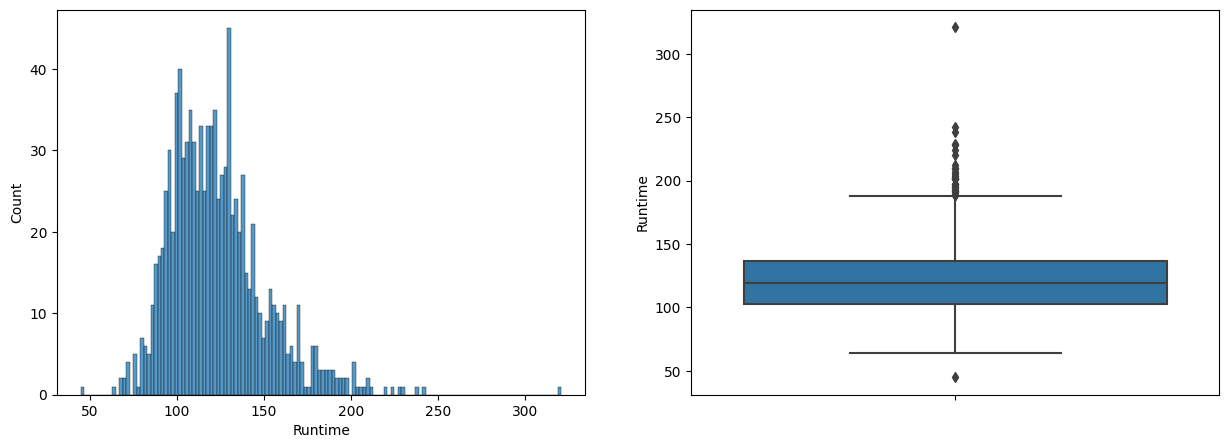

In [336]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.histplot(x="Runtime", data=movie, ax=ax1, binwidth=2)
sns.boxplot(y="Runtime", data=movie, ax=ax2);
movie['Runtime'].describe()

On average, movies among the top 1000 rated have a runtime of approximately 2 hours

#### Do Family-friendly movies have a shorter runtime than age-restricted ones?

,count,mean,std,min,25%,50%,75%,max
Certificate,,,,,,,,
L,283.0,122.674912,32.152457,72.0,100.0,115.0,137.0,238.0
12+,224.0,124.325893,24.550781,45.0,106.0,124.0,141.0,194.0
14+,44.0,117.295455,25.862408,80.0,101.0,114.0,130.0,242.0
16+,345.0,126.095652,27.424730,80.0,108.0,122.0,139.0,321.0


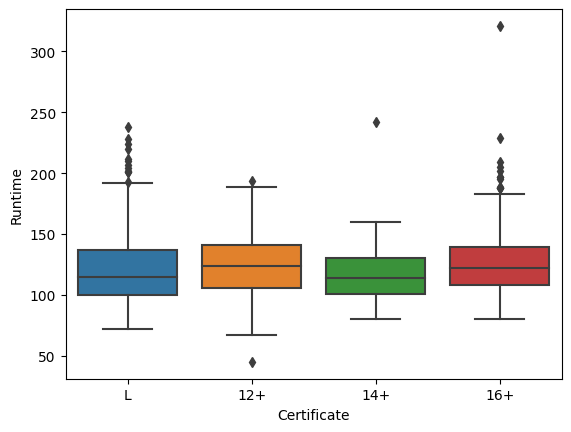

In [337]:
sns.boxplot(x="Certificate", y="Runtime", data=movie);
movie.groupby(by="Certificate")["Runtime"].describe()

Doesn't seem to be the case

#### Released Year

Released Year is in the string format, before converting to float, there is a value (PG) wrongly inserted that must be dealt with.

In [338]:
movie['Released_Year'].value_counts()
movie['Released_Year'] = movie['Released_Year'].map(lambda x: np.nan if x == "PG" else float(x))

#### Are modern films longer than older ones?

<Axes: xlabel='Released_Year', ylabel='Runtime'>

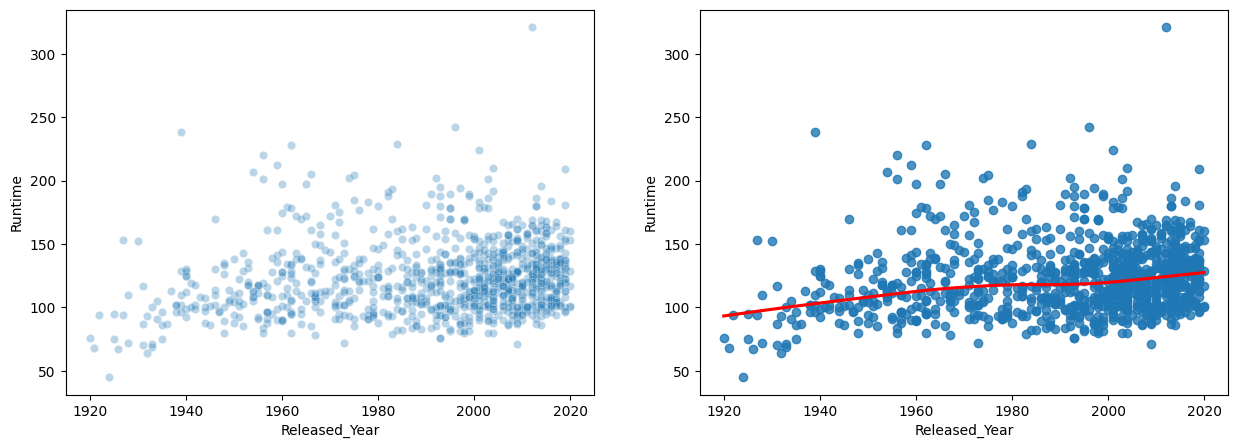

In [339]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)

sns.scatterplot(x="Released_Year", y="Runtime", data=movie, alpha=0.3, ax=ax1);
sns.regplot(x="Released_Year", y="Runtime", data=movie, lowess=True, 
            line_kws={'color': 'red'}, ax=ax2)

There seems to be a mild ascending behavior. Possible guesses for this phenomenon might be:

* Films were harder to produce in the past, therefore they can be shorter on average
* In the beginning, filmmaking was experimental, therefore producers would start small instead of taking a long shot on a lengthy movie.

(Obs: I don't know if that is true, I'd have to talk to a specialist)

However, by following such a reasoning, it is expected that as the film industry matures the average runtime stabilizes, which in practice means that the ascending behavior fades as time goes by. (Like a logarithmic curve). The nonparametric regression (lowess) curve makes explicit such dependence.

In [340]:
movie[['Released_Year', 'Runtime']].corr(method='spearman').iloc[0,1]

0.19317359439015597

Calculating Spearman's correlation (a nonparametric version correlation) between Released_Year and Runtime, we have another indication of their positive correlation.

#### Gross

The gross revenue is a string formatted with commas to separate the thousands, millions, ...

In [341]:
movie['Gross'][1]

'134,966,411'

In [342]:
movie['Gross'] = movie['Gross'].map(lambda x: float(x.replace(',', ''))/10**6 if not pd.isna(x) else np.nan)

#### Do well rated films have a higher revenue?

,index,Gross
0,IMDB_Rating,0.095923
1,Meta_score,-0.030587


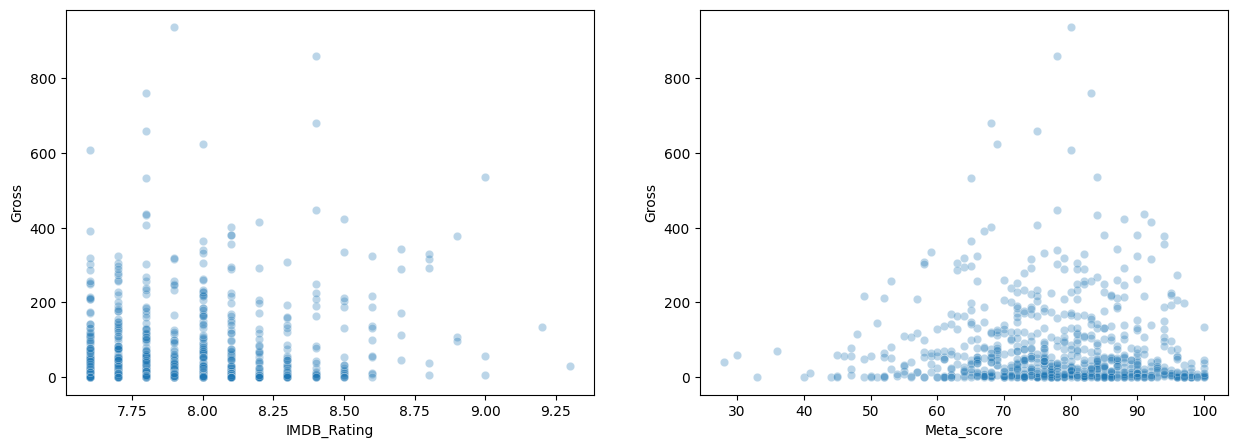

In [343]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.scatterplot(y="Gross", x="IMDB_Rating", data=movie, ax=ax1, alpha=0.3)
sns.scatterplot(y="Gross", x="Meta_score", data=movie, ax=ax2, alpha=0.3)

movie[['IMDB_Rating', 'Meta_score', 'Gross']].corr().iloc[:2,2].reset_index()

Difficult to say something at this point. The scatterplots don't show any evident pattern, and the calculated correlations are small. However, intuitively, we would expect the higher the IMDB_score, the higher the revenue, so, significant or not, the positive correlation of 0.095923 makes sense. As to the relation between specialized critics and revenue, it is hard to expect anything a priori.

# When do the general audience and specialized critics disagree?

,Meta_score,IMDB_Rating
Meta_score,1.000000,0.268531
IMDB_Rating,0.268531,1.000000


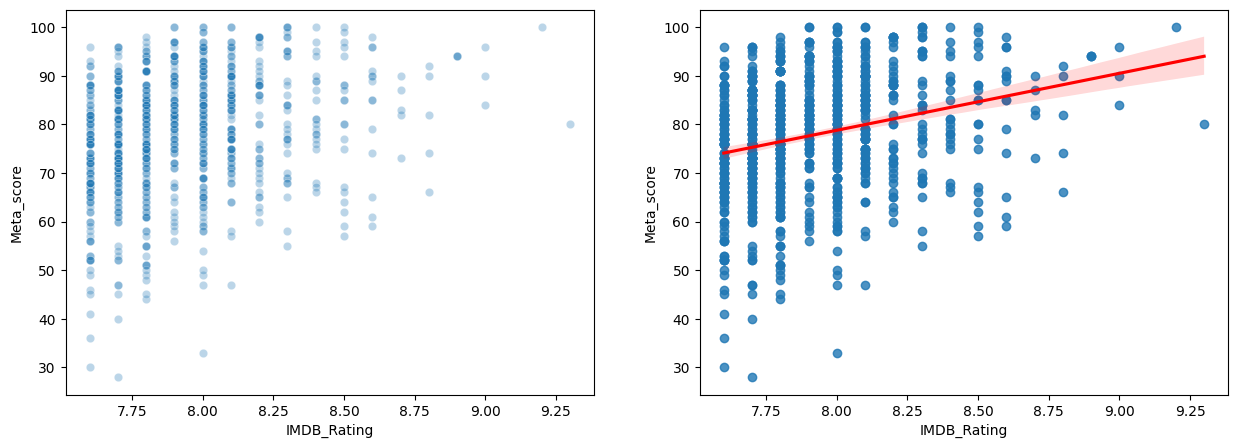

In [344]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.scatterplot(y="Meta_score", x="IMDB_Rating", data=movie, ax=ax1, alpha=0.3)
sns.regplot(x="IMDB_Rating", y="Meta_score", data=movie, 
            line_kws={'color': 'red'}, ax=ax2)
movie[['Meta_score', 'IMDB_Rating']].corr()

#### Approaching the problem with linear regression
I'd like to exclude the influence of IMDB_Rating from Meta_score and then be able to identify the outliers. In order to do that, I'll regress Meta_score against IMDB_Rating and compute the residuals.

In [345]:
lreg = sm.ols('Meta_score ~ IMDB_Rating', data=movie).fit()
lreg.params

Intercept     -14.932402
IMDB_Rating    11.713032
dtype: float64

The coefficient of IMDB_Rating indicates the positive correlation of IMDB_Rating and Meta_Score. Now, calculating the residuals we have

In [346]:
movie['diff'] = movie['Meta_score'] - lreg.fittedvalues
movie['diff'].describe()

count    8.430000e+02
mean     1.541785e-13
std      1.192154e+01
min     -4.725794e+01
25%     -6.871412e+00
50%      1.399452e+00
75%      8.570755e+00
max      2.239945e+01
Name: diff, dtype: float64

<Axes: ylabel='diff'>

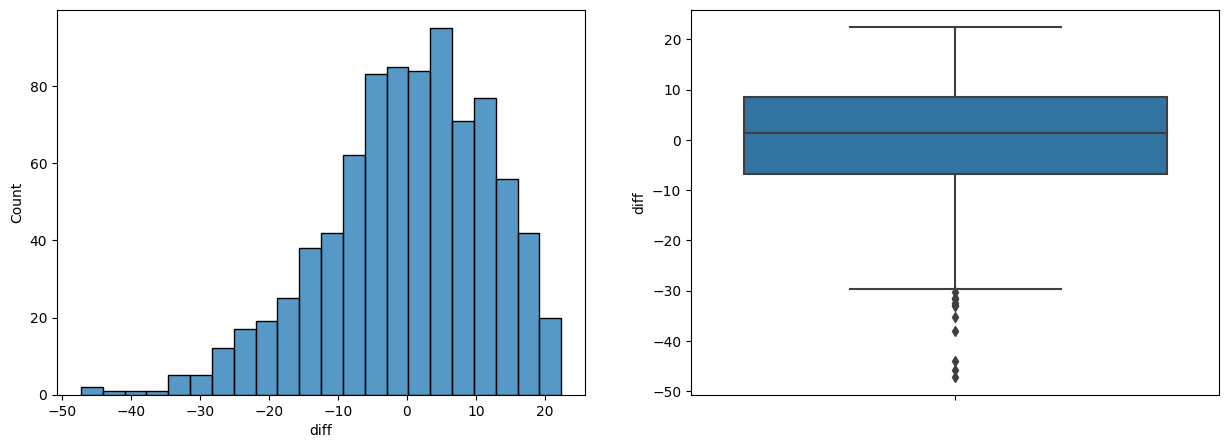

In [347]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.histplot(x="diff", data=movie, ax=ax1)
sns.boxplot(y="diff", data=movie, ax=ax2)

The boxplot indicates many outliers with negative *diff*, films that were well-rated by the general audience (Represented by the fitted line) but poorly rated by critics (Meta_score). The boxplot classifies points as being outliers if they fall outside the following bounds:

In [348]:
IQR = movie['diff'].quantile(0.75) - movie['diff'].quantile(0.25)
out_sup = movie['diff'].quantile(0.75) + IQR*1.5
out_low = movie['diff'].quantile(0.25) - IQR*1.5
(out_low, out_sup) 

(-30.03466352363014, 31.734006216071467)

#### Well-rated by the general audience, but poorly rated by critics

Let's inspect the films that fall below the lower-bound

In [349]:
movie_low = movie[movie['diff'] < out_low] 
movie_low[['Series_Title', 'IMDB_Rating', 'Meta_score', 'diff', 'Genre', 'Runtime', 'Released_Year']].sort_values(by='diff')

,Series_Title,IMDB_Rating,Meta_score,diff,Genre,Runtime,Released_Year
788,I Am Sam,7.7,28.0,-47.257942,Drama,132.0,2001.0
356,Tropa de Elite,8.0,33.0,-45.771851,"Action, Crime, Drama",115.0,2007.0
942,The Butterfly Effect,7.6,30.0,-44.086639,"Drama, Sci-Fi, Thriller",113.0,2004.0
917,Seven Pounds,7.6,36.0,-38.086639,Drama,123.0,2008.0
735,Kai po che!,7.7,40.0,-35.257942,"Drama, Sport",130.0,2013.0
957,Fear and Loathing in Las Vegas,7.6,41.0,-33.086639,"Adventure, Comedy, Drama",118.0,1998.0
272,Pink Floyd: The Wall,8.1,47.0,-32.943154,"Drama, Fantasy, Music",95.0,1982.0
648,The Boondock Saints,7.8,44.0,-32.429245,"Action, Crime, Thriller",108.0,1999.0
397,Bound by Honor,8.0,47.0,-31.771851,"Crime, Drama",180.0,1993.0
677,Predator,7.8,45.0,-31.429245,"Action, Adventure, Sci-Fi",107.0,1987.0


#### Not incredibly well-rated by the general audience, but well-rated by critics

There are no such outliers, which is expected. The dataset consists of the Top 1000 rated IMDB movies, therefore, if the movie had received a poor IMDB rating it wouldn't be present in the dataset, even if the Meta_score was high. In this setting, we cannot establish a clear comparison with the previous case.

However, let's inspect the films with the highest *diff*s

In [350]:
movie[['Series_Title', 'IMDB_Rating', 'Meta_score', 'diff', 'Genre', 'Runtime', 'Released_Year']].sort_values(by='diff', ascending=False).head(11)

,Series_Title,IMDB_Rating,Meta_score,diff,Genre,Runtime,Released_Year
559,Notorious,7.9,100.0,22.399452,"Drama, Film-Noir, Romance",102.0,1946.0
491,Boyhood,7.9,100.0,22.399452,Drama,165.0,2014.0
994,A Hard Day's Night,7.6,96.0,21.913361,"Comedy, Music, Musical",87.0,1964.0
714,The Lady Vanishes,7.8,98.0,21.570755,"Mystery, Thriller",96.0,1938.0
423,Il conformista,8.0,100.0,21.228149,Drama,113.0,1970.0
440,Sweet Smell of Success,8.0,100.0,21.228149,"Drama, Film-Noir",96.0,1957.0
745,Gravity,7.7,96.0,20.742058,"Drama, Sci-Fi, Thriller",91.0,2013.0
720,Roma,7.7,96.0,20.742058,Drama,135.0,2018.0
875,Fantasia,7.7,96.0,20.742058,"Animation, Family, Fantasy",125.0,1940.0
706,Jules et Jim,7.8,97.0,20.570755,"Drama, Romance",105.0,1962.0


#### Interesting insights

* Notice that among the movies with low *diff*, there are plenty of genres Action, Adventure, and Crime, while none of these genres appear among those with high *diff*. That makes sense given that action and adventure movies are much more appealing to the general audience.

* According to Google Bard, when a movie is very experimental, the general public may dislike it while critics appreciate the originality. I'm not a movie expert, but there are experimental movies present in the previous table, such as Boyhood (It took 12 years to film).